Loading datasets...
Datasets loaded successfully

Comparing autoencoder variants...

Training Three Layer AE...
Epoch [10/40], Loss: 0.073688
Epoch [20/40], Loss: 0.069300
Epoch [30/40], Loss: 0.067676
Epoch [40/40], Loss: 0.066718

Training Tied Weights AE...
Epoch [10/40], Loss: 0.070830
Epoch [20/40], Loss: 0.068180
Epoch [30/40], Loss: 0.067308
Epoch [40/40], Loss: 0.066746

Training Pseudoinverse AE...
Epoch [10/40], Loss: 0.073334
Epoch [20/40], Loss: 0.070542
Epoch [30/40], Loss: 0.069282
Epoch [40/40], Loss: 0.068518

Reconstruction MSE Comparison:
--------------------------------------------------
Model                     MSE            
--------------------------------------------------
Three Layer AE            0.002259       
Tied Weights AE           0.002038       
Pseudoinverse AE          0.002308       
--------------------------------------------------


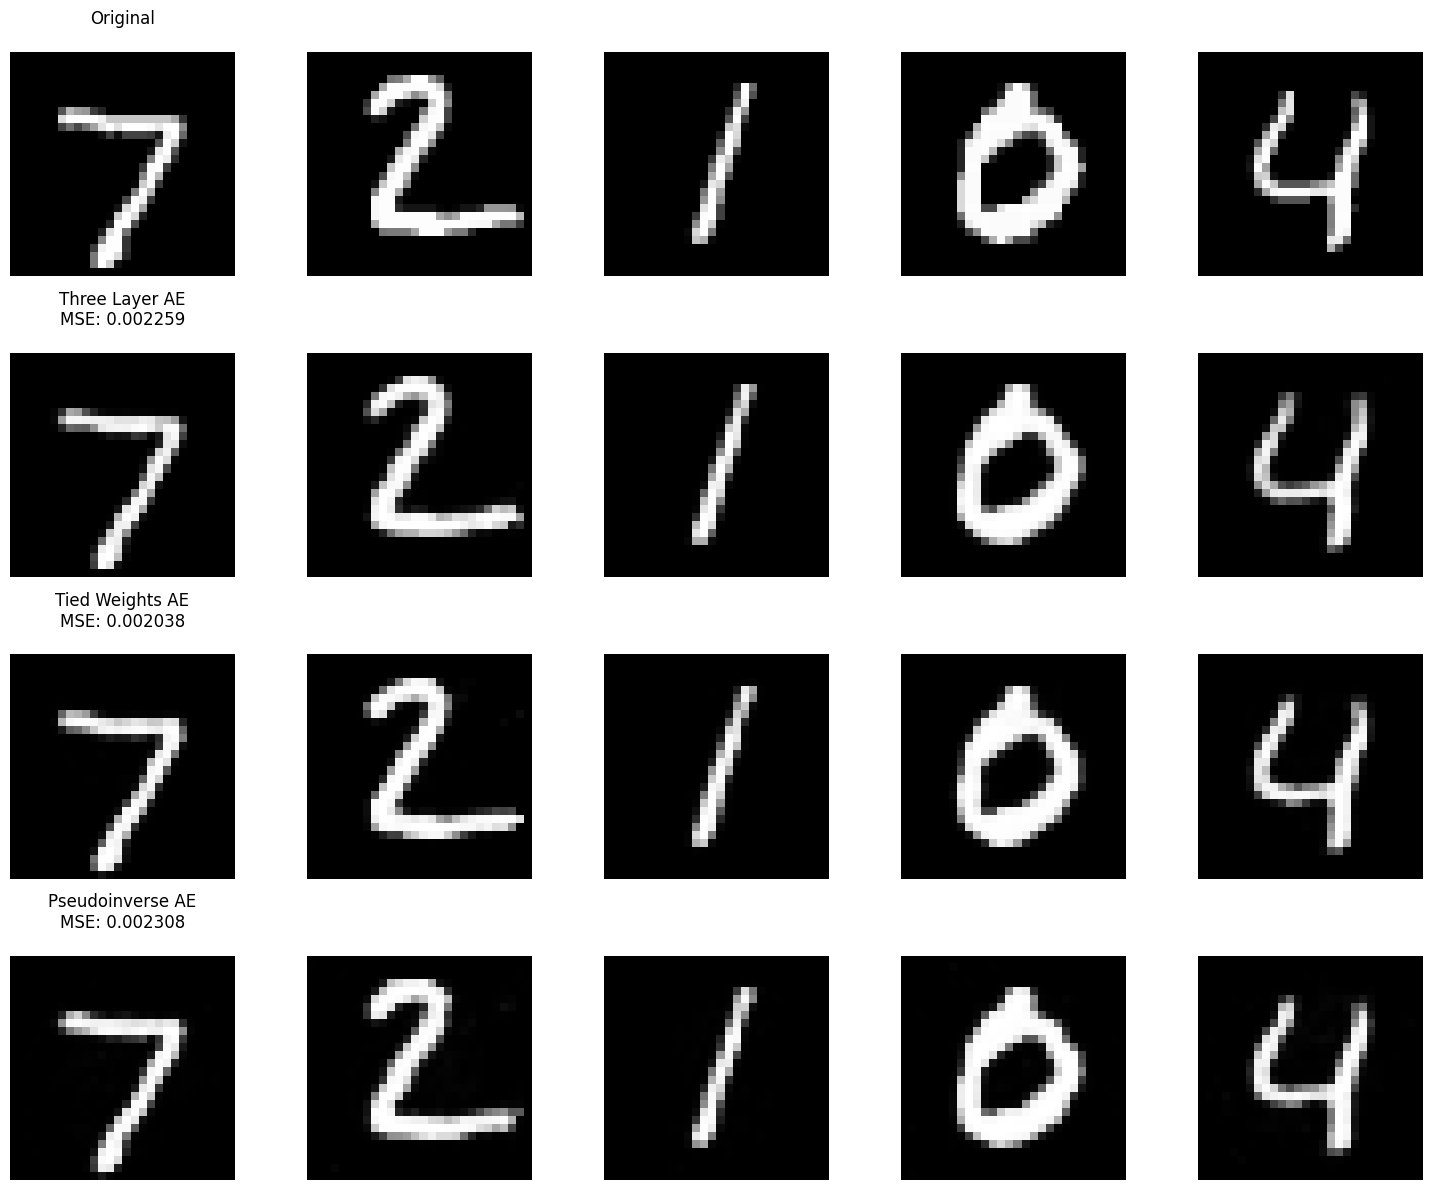

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple


# Dataset class
class MNISTDataset(Dataset):
    def __init__(self, csv_file):
        data = pd.read_csv(csv_file)
        self.labels = data.iloc[:, 0].values
        self.features = data.iloc[:, 1:].values
        self.features = self.features / 255.0
        self.features = self.features - np.mean(self.features, axis=0)
        min_vals = np.min(self.features, axis=0)
        max_vals = np.max(self.features, axis=0)
        self.features = (self.features - min_vals) / (max_vals - min_vals + 1e-8)
        self.features = torch.FloatTensor(self.features)
        self.labels = torch.LongTensor(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# Training function
def train_model(model, train_loader, num_epochs=40, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data.view(data.size(0), -1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.6f}')


def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device) -> float:
    """Calculate MSE reconstruction error on test dataset"""
    model.eval()
    total_mse = 0.0
    num_samples = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            reconstructed = model(data)
            mse = F.mse_loss(reconstructed, data.view(data.size(0), -1))
            total_mse += mse.item() * data.size(0)
            num_samples += data.size(0)

    return total_mse / num_samples


# Import the three autoencoder variants
from autoencoder_mnist_3 import Autoencoder as ThreeLayerAutoencoder
from autoencoder_mnist_4 import PseudoinverseAutoencoder
from autoencoder_mnist_3 import TiedAutoencoder  # This should be in your autoencoder_mnist_3.py file


def compare_autoencoders(train_loader: DataLoader, test_loader: DataLoader) -> Tuple[Dict[str, float], plt.Figure]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize models
    models = {
        'Three Layer AE': ThreeLayerAutoencoder(input_size=784, latent_size=128),
        'Tied Weights AE': TiedAutoencoder(input_size=784, latent_size=128),
        'Pseudoinverse AE': PseudoinverseAutoencoder(input_size=784, latent_size=128)
    }

    # Move models to device
    for model in models.values():
        model.to(device)

    # Train models and collect MSE scores
    mse_scores = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        train_model(model, train_loader)
        mse = evaluate_model(model, test_loader, device)
        mse_scores[name] = mse

    # Create visualization comparing reconstructions
    fig = plt.figure(figsize=(15, 12))
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:5].to(device)

        # Plot original images in first row
        for i in range(5):
            plt.subplot(4, 5, i + 1)
            plt.imshow(data[i].cpu().view(28, 28), cmap='gray')
            if i == 0:
                plt.title('Original', pad=20)
            plt.axis('off')

        # Plot reconstructions for each model
        for row, (name, model) in enumerate(models.items(), start=1):
            reconstructed = model(data)
            for i in range(5):
                plt.subplot(4, 5, row * 5 + i + 1)
                plt.imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
                if i == 0:
                    plt.title(f'{name}\nMSE: {mse_scores[name]:.6f}', pad=20)
                plt.axis('off')

    plt.tight_layout()
    return mse_scores, fig


def print_mse_table(mse_scores: Dict[str, float]):
    """Print MSE scores in a formatted table"""
    print("\nReconstruction MSE Comparison:")
    print("-" * 50)
    print(f"{'Model':<25} {'MSE':<15}")
    print("-" * 50)
    for name, mse in mse_scores.items():
        print(f"{name:<25} {mse:<15.6f}")
    print("-" * 50)


def main():
    # Load datasets
    print("Loading datasets...")
    train_dataset = MNISTDataset('mnist_train.csv')
    test_dataset = MNISTDataset('mnist_test.csv')

    train_loader = DataLoader(train_dataset, batch_size=250, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=250, shuffle=False)
    print("Datasets loaded successfully")

    # Compare models
    print("\nComparing autoencoder variants...")
    mse_scores, fig = compare_autoencoders(train_loader, test_loader)

    # Print results table
    print_mse_table(mse_scores)

    # Show comparison plot
    plt.show()


if __name__ == "__main__":
    main()